In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import neuromaps

import seaborn as sns
from neuromaps import datasets, transforms, images, resampling, nulls, stats
from scipy.stats import zscore, rankdata

In [54]:
print("neuromaps version:", neuromaps.__version__)

neuromaps version: 0.0.5+41.gf0ed67c


In [ ]:
!wb_command -version

In [55]:
## run if needed
# pip install neuromaps brainspace
# pip install statsmodels

In [2]:
# Add more imports if needed

from neuromaps.datasets import fetch_atlas ## used to access the templates for the coordinate system
import nibabel as nib ## used to load system dictionary per key
from neuromaps.datasets import available_annotations ## repository of brain maps - spatial maps representing some
from neuromaps.datasets import available_tags ## most annotations have “tags” that help to describe the data they represent
from neuromaps.datasets import fetch_annotation
from neuromaps.datasets import fetch_fsaverage

from neuromaps import transforms
import netneurotools
# possibly need
from netneurotools import datasets as nntdata
from neuromaps import parcellate
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
# plotting 
from neuromaps.images import load_data
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from neuromaps import plotting
from nilearn import plotting
import numpy as np
import pandas as pd
# sampling
from neuromaps import datasets, images, nulls, resampling
from neuromaps.resampling import resample_images
from neuromaps.stats import compare_images
from neuromaps import stats
from nilearn.datasets import fetch_atlas_surf_destrieux
from neuromaps.nulls import alexander_bloch
from neuromaps.stats import compare_images
from scipy.stats import pearsonr

from nilearn.surface import load_surf_mesh
from brainspace.null_models import SpinPermutations
from nilearn.surface import InMemoryMesh, PolyMesh
from nilearn.surface import SurfaceImage
from nilearn.plotting import view_surf

import time
# from neuromaps.stats import fdr_correct
# for FDR
from statsmodels.stats.multitest import multipletests

In [57]:
for annotation in available_annotations():
    print(annotation)

('abagen', 'genepc1', 'fsaverage', '10k')
('aghourian2017', 'feobv', 'MNI152', '1mm')
('alarkurtti2015', 'raclopride', 'MNI152', '3mm')
('bedard2019', 'feobv', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'fsaverage', '164k')
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
('beliveau2017', 'cimbi36', 'fsaverage', '164k')
('beliveau2017', 'cumi101', 'MNI152', '1mm')
('beliveau2017', 'cumi101', 'fsaverage', '164k')
('beliveau2017', 'dasb', 'MNI152', '1mm')
('beliveau2017', 'dasb', 'fsaverage', '164k')
('beliveau2017', 'sb207145', 'MNI152', '1mm')
('beliveau2017', 'sb207145', 'fsaverage', '164k')
('castrillon2023', 'cmrglc', 'MNI152', '3mm')
('ding2010', 'mrb', 'MNI152', '1mm')
('dubois2015', 'abp688', 'MNI152', '1mm')
('dukart2018', 'flumazenil', 'MNI152', '3mm')
('dukart2018', 'fpcit', 'MNI152', '3mm')
('fazio2016', 'madam', 'MNI152', '3mm')
('finnema2016', 'ucbj', 'MNI152', '1mm')
('gallezot2010', 'p943', 'MNI152', '1mm')
('gallezot2017',

#### Tuples for the brain maps we're going to use
**subject to change tho**

In [58]:
# other brain maps
# Physical maps
('abagen', 'genepc1', 'fsaverage', '10k')
('hcps1200', 'myelinmap', 'fsLR', '32k')
('hcps1200', 'thickness', 'fsLR', '32k')
('reardon2018', 'scalingnih', 'civet', '41k')
# Chemical maps
('savli2012', 'way100635', 'MNI152', '3mm') ## 5ht1a brain map
('margulies2016', 'fcgradient01', 'fsLR', '32k')
('raichle', 'cmrglc', 'fsLR', '164k')
('mueller2013', 'intersubjvar', 'fsLR', '164k')

('mueller2013', 'intersubjvar', 'fsLR', '164k')

In [59]:
# ## Maybe add more receptor maps
# ('smart2019', 'abp688', 'MNI152', '1mm') # ABP688 mGluR5 - controls the ability for the brain to rewire its connections and learn new things
# ('turtonen2020', 'carfentanil', 'MNI152', '1mm') # Carfentanil MOR - endorphins, responsible for feelings of euphoria & pain
# ...('kantonen2020', 'carfentanil', 'MNI152', '3mm')  #??

#### 5Ht1a brain map

get MNI data and transform it into fsLR 32k

ideally make everything into fsLR 32k

In [60]:
# mni152 = fetch_atlas('MNI152', '3mm')
# print(sorted(mni152))

In [61]:
five_ht1a = fetch_annotation(source='savli2012', desc='way100635', space='MNI152', den='3mm')


[References] Please cite the following papers if you are using this data:

  For {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'}:
  [primary]:
    Markus Savli, Andreas Bauer, Markus Mitterhauser, Yu-Shin Ding, Andreas Hahn, Tina Kroll, Alexander Neumeister, Daniela Haeusler, Johanna Ungersboeck, Shannan Henry, and others. Normative database of the serotonergic system in healthy subjects using multi-tracer pet. Neuroimage, 63(1):447–459, 2012.
  [secondary]:
    


In [62]:
fslr_5ht1a = transforms.mni152_to_fslr(five_ht1a, '32k')
fslr_5ht1a
#The returned fslr object is a tuple of nib.GiftiImage objects corresponding to data from the (left, right) hemisphere. 
# These data can be accessed via the .agg_data() method on the image objects:

(<nibabel.gifti.gifti.GiftiImage at 0x30230d4d0>,
 <nibabel.gifti.gifti.GiftiImage at 0x16863b890>)

In [63]:
fslr_lh, fslr_rh = fslr_5ht1a
print(fslr_lh.agg_data().shape)

(32492,)


In [64]:
five_ht1a_data = load_data(fslr_5ht1a)
five_ht1a_data

array([37.421368, 27.300804, 23.448963, ..., 44.939358, 44.68842 ,
       43.892735], shape=(64984,), dtype=float32)

In [65]:
# fig = neuromaps.plotting.plot_surf_template(
#     data=fslr_5ht1a,
#     template='fsLR',
#     density='32k',
#     surf='inflated',          
#     cmap='plasma',
#     colorbar=True,
# )
# fig.suptitle("5HT1a (fsLR 32k)", fontsize=16, y=0.9)
# fig.show()

/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_45468/1722637415.py:15: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_45468/1722637415.py:30: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


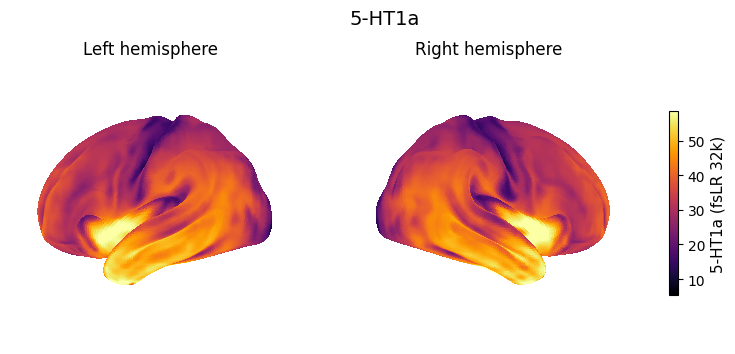

In [66]:
vmin, vmax = np.percentile(five_ht1a_data[~np.isnan(five_ht1a_data)], [2, 98])

# Fetch fsLR 32k surfaces
fslr = fetch_atlas('fsLR', density='32k')
surf_l = fslr['inflated'].L
surf_r = fslr['inflated'].R

data_l = load_data(fslr_5ht1a[0])
data_r = load_data(fslr_5ht1a[1])

fig = plt.figure(figsize=(10, 4))

# left hemi
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_l,
    surf_map=data_l,
    hemi='left',
    view='lateral',
    cmap='inferno',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax1,
    title='Left hemisphere'
)

# right hemi
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_r,
    surf_map=data_r,
    hemi='right',
    view='lateral',
    cmap='inferno',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax2,
    title='Right hemisphere'
)
# color bar
sm = plt.cm.ScalarMappable(cmap='inferno')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('5-HT1a (fsLR 32k)', fontsize=11)

plt.suptitle("5-HT1a", fontsize=14)
plt.show()

## Fetch annotation and loading data

Transforming Brain maps into fsLR 32k if not already in this coordinate space

In [67]:
# PC1 Gene Expression
# The only case when we're transform upstream

pc1_gene = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
PC1_gene_exp = neuromaps.transforms.fsaverage_to_fslr(pc1_gene, '32k')
pc1_gene_data = load_data(PC1_gene_exp)


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


In [68]:
# Myelin Ratio
tw1_tw2_ratio = fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k')
myelin_data = load_data(tw1_tw2_ratio)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


In [69]:
# Cortical Thickness
cort_thickness = fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k')
cort_thickness_data = load_data(cort_thickness)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


In [70]:
# NIH Allometric Scaling
NIH_scaling = fetch_annotation(source='reardon2018', desc='scalingnih', space='civet', den='41k')
NIH_scaling_transform = neuromaps.transforms.civet_to_fslr(NIH_scaling, '32k')
NIH_scaling_data = load_data(NIH_scaling_transform)


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


In [71]:
# Functional Gradient
func_grad = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
func_gradient_data = load_data(func_grad)


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    


In [72]:
# Glucose metabolism
gluc_metab = fetch_annotation(source='raichle', desc='cmrglc', space='fsLR', den='164k')
gluc_metab_transform = neuromaps.transforms.fslr_to_fslr(gluc_metab, '32k')
gluc_metab_data = load_data(gluc_metab_transform)


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


In [73]:
# Intersubject Variability
intersub_var = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')
intersub_var_transform = neuromaps.transforms.fslr_to_fslr(intersub_var, '32k')
intersub_var_data = load_data(intersub_var_transform)


[References] Please cite the following papers if you are using this data:

  For {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Sophia Mueller, Danhong Wang, Michael D Fox, BT Thomas Yeo, Jorge Sepulcre, Mert R Sabuncu, Rebecca Shafee, Jie Lu, and Hesheng Liu. Individual variability in functional connectivity architecture of the human brain. Neuron, 77(3):586–595, 2013.
  [secondary]:
    


## New Implementation

In [ ]:
brain_maps = [
    {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'},
    {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'},
    {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'},
    {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'},
    {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'},
    {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'},
    {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'},
    {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}
]

single_sphere_counter = 0
for map in brain_maps:
    brain_map = datasets.fetch_annotation(**map)
    if len(brain_map) != 2:
        single_sphere_counter += 1
        print(map)
print(single_sphere_counter)


## Kevin S added
readable_map_names = {
    'genepc1': 'PC1 Gene Expression',
    'myelinmap': 'T1w/T2w Ratio',
    'thickness': 'Cortical Thickness',
    'fcgradient01': 'Functional Gradient',
    'intersubjvar': 'Intersubject Variability',
    'cmrglc': 'Glucose Metabolism',
    'scalingnih': 'Allometric Scaling (NIH)',
    'way100635':' 5-HT1A Receptor'
}

def is_volumetric(map_dict):
    """Check if a map is volumetric (MNI space)"""
    return map_dict.get('space') in ['MNI152', 'MNI305']

In [ ]:
def load_and_prepare_map(map_dict, readable_map_names=None, target_space='fsLR', target_den='32k'):
    """
    Load a brain map and prepare it for analysis
    - Volumetric maps: transform to surface
    - Surface maps: resample if needed, use both hemispheres
    - return (transformed data array, space, density)
    """
    # Determine display name for logging
    desc = map_dict['desc']
    if readable_map_names and desc in readable_map_names:
        display_name = readable_map_names[desc]
    else:
        display_name = desc
    
    # Fetch the map
    brain_map = datasets.fetch_annotation(**map_dict)
    
    # Check if volumetric
    if is_volumetric(map_dict):
        print(f"Volumetric map detected, transforming to {target_space} surface...")
        
        # Transform volumetric to surface (both hemispheres)
        try:
            surface_map = transforms.mni152_to_fslr(brain_map, fslr_density=target_den)
            # surface_map will be a tuple of (left_hemi, right_hemi)
            lh_data = images.load_data(surface_map[0])
            rh_data = images.load_data(surface_map[1])
            full_data = np.hstack([lh_data, rh_data])
            return full_data, target_space, target_den
            
        except Exception as e:
            print(f"    Warning: Could not transform volumetric map: {e}")
 
    # Surface map processing
    else:
        src_space = map_dict.get('space')
        src_den = map_dict.get('den')
        template = {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}
        template_map = datasets.fetch_annotation(**template)
        # Load both hemispheres
        if len(brain_map) == 2:
            lh_map, rh_map = brain_map
        else:
            raise ValueError(f"Expected 2 hemispheres for surface map, got {len(brain_map)}")
        
        if src_den != target_den or src_space != target_space:
            print(f"Resampling from {src_space}-{src_den} to {target_space}-{target_den}...")            
            # Resample both hemispheres
            lh_resampled, _ = resampling.resample_images(
                lh_map, template_map[0],
                src_space=src_space, trg_space=target_space,
                hemi='L', resampling='transform_to_trg'
            )
            rh_resampled, _ = resampling.resample_images(
                rh_map, template_map[1],
                src_space=src_space, trg_space=target_space,
                hemi='R', resampling='transform_to_trg'
            )
            
            lh_data = images.load_data(lh_resampled)
            rh_data = images.load_data(rh_resampled)
        else:
            lh_data = images.load_data(lh_map)
            rh_data = images.load_data(rh_map)
        
        full_data = np.hstack([lh_data, rh_data])
        return full_data, src_space if src_den == target_den else target_space, \
               src_den if src_den == target_den else target_den

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

def compute_preliminary_matrix(prepared_maps, map_names, nulls_list, n_perm=1000, readable_map_names=None):
    """
    Computes a PRELIMINARY correlation matrix with standard Spin Tests (Uncorrected).
    Use this for your initial exploration.
    
    Parameters:
    - prepared_maps: List of numpy arrays (N_vertices,) for each map.
    - map_names: List of strings naming each map.
    - nulls_list: List of null arrays (N_vertices, n_perm) for each map.
    - n_perm: Number of permutations used (default 1000).
    - readable_map_names: Dictionary mapping map keys (desc) to readable strings.
    """
    
    print("--- Step 1: Global Masking & Standardization ---")
    data_stack = np.column_stack(prepared_maps)
    
    # Global Mask: Remove vertices where ANY map is missing data
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    print(f"Clean vertices used for analysis: {n_vertices_clean}")
    
    # Z-Score to standardize units (Correlation == Covariance)
    clean_data_z = zscore(clean_data, axis=0)
    
    print("\n--- Step 2: Compute Real Correlation Matrix (Pearson) ---")
    real_corr = (clean_data_z.T @ clean_data_z) / n_vertices_clean
    
    print("\n--- Step 3: Compute Spin P-Values (Uncorrected) ---")
    p_counts = np.zeros((len(prepared_maps), len(prepared_maps)))
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    for k in range(n_perm):
        if k % 100 == 0: print(f"Permutation {k}/{n_perm}...")
        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            null_data_k[:, m] = zscore(spin_k, nan_policy='omit')
            
        null_corr_k = np.corrcoef(null_data_k.T)
        
        # Check: Is random correlation stronger than real correlation?
        is_stronger = np.abs(null_corr_k) >= np.abs(real_corr)
        p_counts += is_stronger.astype(int)

    p_values = (p_counts + 1) / (n_perm + 1)
    
    print("\n--- Step 4: Finalizing ---")
    
    # Resolve readable names for the DataFrame columns/indices
    display_names = map_names
    if readable_map_names is not None:
        display_names = []
        for name in map_names:
            # name is typically "source_desc" (e.g. abagen_genepc1)
            # readable_map_names keys are typically "desc" (e.g. genepc1)
            
            # 1. Check for direct match
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
                
            # 2. Check if name ends with "_desc" corresponding to a key
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            
            if not found_match:
                display_names.append(name) # Fallback to original if no match found
    
    df_corr = pd.DataFrame(real_corr, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(p_values, index=display_names, columns=display_names).round(3)
    
    # Mask non-significant values (p > 0.05)
    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0
    
    return df_corr, df_pvals, df_significant

def plot_correlation_heatmaps(df_corr, df_significant):
    """
    Plots two side-by-side heatmaps: 
    1. The Full Correlation Matrix
    2. The Significant-Only Matrix (Non-significant cells masked)
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # Increased height for rotated labels
    
    # Plot 1: Full Matrix
    sns.heatmap(
        df_corr, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        ax=axes[0],
        cbar_kws={'label': 'Pearson r'}
    )
    axes[0].set_title("Full Correlation Matrix (Raw)", fontsize=16)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # Plot 2: Significant Only
    # Create a mask for zero values (non-significant) so they appear white/grey
    mask = (df_significant == 0)
    
    sns.heatmap(
        df_significant, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        mask=mask, # Hides the non-significant cells
        ax=axes[1],
        cbar_kws={'label': 'Pearson r'}
    )
    axes[1].set_title("Significant Correlations Only (p < 0.05)", fontsize=16)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

In [ ]:
prepared_maps = []
map_names = []
nulls_list = []
n_perm = 1000

for i, b_map in enumerate(brain_maps):
    prep_data, _, _ = load_and_prepare_map(
        b_map, 
        readable_map_names=readable_map_names, 
        target_space='fsLR', 
        target_den='32k'
    )
    prepared_maps.append(prep_data)

    name = f"{b_map['source']}_{b_map['desc']}"
    map_names.append(name)

    desc = b_map['desc']
    display_name = readable_map_names.get(desc, desc)
    
    print(f"Generating {n_perm} spins for {display_name}...")
    rotated = nulls.alexander_bloch(
        prep_data, 
        atlas='fsLR', 
        density='32k', 
        n_perm=n_perm, 
        seed=1234 + i 
    )
    nulls_list.append(rotated)

# takes about 12 min to run

In [ ]:
df_corr, df_pvals, df_significant = compute_preliminary_matrix(
    prepared_maps, 
    map_names, 
    nulls_list, 
    n_perm=1000,
    readable_map_names=readable_map_names
)

print("\n--- Correlation Matrix (Pearson r) ---")
display(df_corr)

print("\n--- Significant Correlations (p < 0.05) ---")
display(df_significant)

plot_correlation_heatmaps(df_corr, df_significant)

In [ ]:
from scipy.stats import zscore, rankdata
## Spearman Rank
def compute_preliminary_matrix_spearman(prepared_maps, map_names, nulls_list, n_perm=1000, readable_map_names=None):
    """
    correlation matrix using SPEARMAN RANK CORRELATION.
    Use this if your data has non-linear monotonic relationships.
    
    Parameters:
    - prepared_maps: List of numpy arrays (N_vertices,) for each map.
    - map_names: List of strings naming each map.
    - nulls_list: List of null arrays (N_vertices, n_perm) for each map.
    - n_perm: Number of permutations used (default 1000).
    - readable_map_names: Dictionary mapping map keys (desc) to readable strings.
    """

    data_stack = np.column_stack(prepared_maps)

    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    
    # TRANSFORMATION FOR SPEARMAN: Rank the data
    # We rank down each column (axis=0)
    # This converts raw values to ranks (1st, 2nd, 3rd...)
    # NOTE: This is where Spearman differs from Pearson
    clean_data_ranked = np.apply_along_axis(rankdata, 0, clean_data)
    
    # Z-Score the RANKS (Standardization)
    # Pearson on Ranks == Spearman on Raw Data
    clean_data_z = zscore(clean_data_ranked, axis=0)
    
    print("\n--- Step 2: Compute Real Correlation Matrix (Spearman) ---")

    real_corr = (clean_data_z.T @ clean_data_z) / n_vertices_clean
    
    print("\n--- Step 3: Compute Spin P-Values (Uncorrected) ---")
    p_counts = np.zeros((len(prepared_maps), len(prepared_maps)))
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    for k in range(n_perm):
        if k % 100 == 0: print(f"Permutation {k}/{n_perm}...")
        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            
            # CRITICAL: We must RANK the null data too for valid Spearman comparison
            # Handle NaNs if spins introduced them (though global mask helps)
            spin_k_ranked = rankdata(spin_k, nan_policy='omit')
            
            null_data_k[:, m] = zscore(spin_k_ranked, nan_policy='omit')
            
        null_corr_k = np.corrcoef(null_data_k.T)
        
        # Check: Is random correlation stronger than real correlation?
        is_stronger = np.abs(null_corr_k) >= np.abs(real_corr)
        p_counts += is_stronger.astype(int)

    p_values = (p_counts + 1) / (n_perm + 1)
    
    display_names = map_names
    if readable_map_names is not None:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match:
                display_names.append(name)
    
    df_corr = pd.DataFrame(real_corr, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(p_values, index=display_names, columns=display_names).round(3)
    
    # Mask non-significant values (p > 0.05)
    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0
    
    return df_corr, df_pvals, df_significant

In [ ]:
df_corr, df_pvals, df_significant = compute_preliminary_matrix_spearman(
    prepared_maps, 
    map_names, 
    nulls_list, 
    n_perm=1000,
    readable_map_names=readable_map_names
)

print("\n--- Correlation Matrix (Spearman rho) ---")
display(df_corr)

print("\n--- Significant Correlations (p < 0.05) ---")
display(df_significant)

plot_correlation_heatmaps(df_corr, df_significant)

### EDA - Scatterplots
to check if relationships are pearson or spearman
    - or if we need special cases

In [3]:
brain_maps = [
    {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'},
    {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'},
    {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'},
    {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'},
    {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'},
    {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'},
    {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'},
    {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}
]

single_sphere_counter = 0
for map in brain_maps:
    brain_map = datasets.fetch_annotation(**map)
    if len(brain_map) != 2:
        single_sphere_counter += 1
        print(map)
print(single_sphere_counter)

readable_map_names = {
    'genepc1': 'PC1 Gene Expression',
    'myelinmap': 'T1w/T2w Ratio',
    'thickness': 'Cortical Thickness',
    'fcgradient01': 'Functional Gradient',
    'intersubjvar': 'Intersubject Variability',
    'cmrglc': 'Glucose Metabolism',
    'scalingnih': 'Allometric Scaling (NIH)',
    'way100635':' 5-HT1A Receptor'
}

def is_volumetric(map_dict):
    """Check if a map is volumetric (MNI space)"""
    return map_dict.get('space') in ['MNI152', 'MNI305']


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jespe

In [4]:
def load_and_prepare_map(map_dict, readable_map_names=None, target_space='fsLR', target_den='32k'):
    """
    Load a brain map and prepare it for analysis
    - Volumetric maps: transform to surface
    - Surface maps: resample if needed, use both hemispheres
    - return (transformed data array, space, density)
    """
    # Determine display name for logging
    desc = map_dict['desc']
    if readable_map_names and desc in readable_map_names:
        display_name = readable_map_names[desc]
    else:
        display_name = desc
    
    # Fetch the map
    brain_map = datasets.fetch_annotation(**map_dict)
    
    # Check if volumetric
    if is_volumetric(map_dict):
        print(f"Volumetric map detected, transforming to {target_space} surface...")
        
        # Transform volumetric to surface (both hemispheres)
        try:
            surface_map = transforms.mni152_to_fslr(brain_map, fslr_density=target_den)
            # surface_map will be a tuple of (left_hemi, right_hemi)
            lh_data = images.load_data(surface_map[0])
            rh_data = images.load_data(surface_map[1])
            full_data = np.hstack([lh_data, rh_data])
            return full_data, target_space, target_den
            
        except Exception as e:
            print(f"    Warning: Could not transform volumetric map: {e}")
 
    # Surface map processing
    else:
        src_space = map_dict.get('space')
        src_den = map_dict.get('den')
        template = {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}
        template_map = datasets.fetch_annotation(**template)
        # Load both hemispheres
        if len(brain_map) == 2:
            lh_map, rh_map = brain_map
        else:
            raise ValueError(f"Expected 2 hemispheres for surface map, got {len(brain_map)}")
        
        if src_den != target_den or src_space != target_space:
            print(f"Resampling from {src_space}-{src_den} to {target_space}-{target_den}...")            
            # Resample both hemispheres
            lh_resampled, _ = resampling.resample_images(
                lh_map, template_map[0],
                src_space=src_space, trg_space=target_space,
                hemi='L', resampling='transform_to_trg'
            )
            rh_resampled, _ = resampling.resample_images(
                rh_map, template_map[1],
                src_space=src_space, trg_space=target_space,
                hemi='R', resampling='transform_to_trg'
            )
            
            lh_data = images.load_data(lh_resampled)
            rh_data = images.load_data(rh_resampled)
        else:
            lh_data = images.load_data(lh_map)
            rh_data = images.load_data(rh_map)
        
        full_data = np.hstack([lh_data, rh_data])
        return full_data, src_space if src_den == target_den else target_space, \
               src_den if src_den == target_den else target_den

In [5]:
prepared_maps = []
map_names = []
nulls_list = []
n_perm = 1000

for i, b_map in enumerate(brain_maps):
    prep_data, _, _ = load_and_prepare_map(
        b_map, 
        readable_map_names=readable_map_names, 
        target_space='fsLR', 
        target_den='32k'
    )
    prepared_maps.append(prep_data)

    name = f"{b_map['source']}_{b_map['desc']}"
    map_names.append(name)

    desc = b_map['desc']
    display_name = readable_map_names.get(desc, desc)
    
    print(f"Generating {n_perm} spins for {display_name}...")
    rotated = nulls.alexander_bloch(
        prep_data, 
        atlas='fsLR', 
        density='32k', 
        n_perm=n_perm, 
        seed=1234 + i 
    )
    nulls_list.append(rotated)

# takes about 12 min to run


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jespe

In [6]:
from scipy.stats import pearsonr, spearmanr
def plot_pairwise_scatterplots(prepared_maps, map_names, readable_map_names=None):
    # data prep
    # 32k rows 8 columns
    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    clean_data = data_stack[global_mask]
    
    n_maps = len(prepared_maps)
    
    # making sure brain maps names exist and are readable
    display_names = map_names
    if readable_map_names:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            
            if not found_match:
                display_names.append(name)

    import math
    # 28 unique pairs
    n_pairs = (n_maps * (n_maps - 1)) // 2
    n_cols = 4
    n_rows = math.ceil(n_pairs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()
    
    plot_idx = 0
    
    for i in range(n_maps):
        for j in range(i + 1, n_maps):
            ax = axes[plot_idx]
            
            x = clean_data[:, i]
            y = clean_data[:, j]
            r, _ = pearsonr(x, y)
            rho, _ = spearmanr(x, y)
            # use hexbin for density instead of scatter plot because of ~32k points
            hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1, bins='log')
            # add trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_range = np.linspace(x.min(), x.max(), 100)
            ax.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)
            
            ax.set_xlabel(display_names[i], fontsize=8)
            ax.set_ylabel(display_names[j], fontsize=8)
            
            # Green if metrics agree (diff < 0.1), Red if they diverge
            diff = abs(r - rho)
            title_color = 'green' if diff < 0.1 else 'red'
            
            ax.set_title(f"r={r:.2f} | ρ={rho:.2f}", fontsize=10, color=title_color, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            plot_idx += 1
        
    for k in range(plot_idx, len(axes)):
        axes[k].axis('off')
        
    plt.tight_layout()
    plt.show()

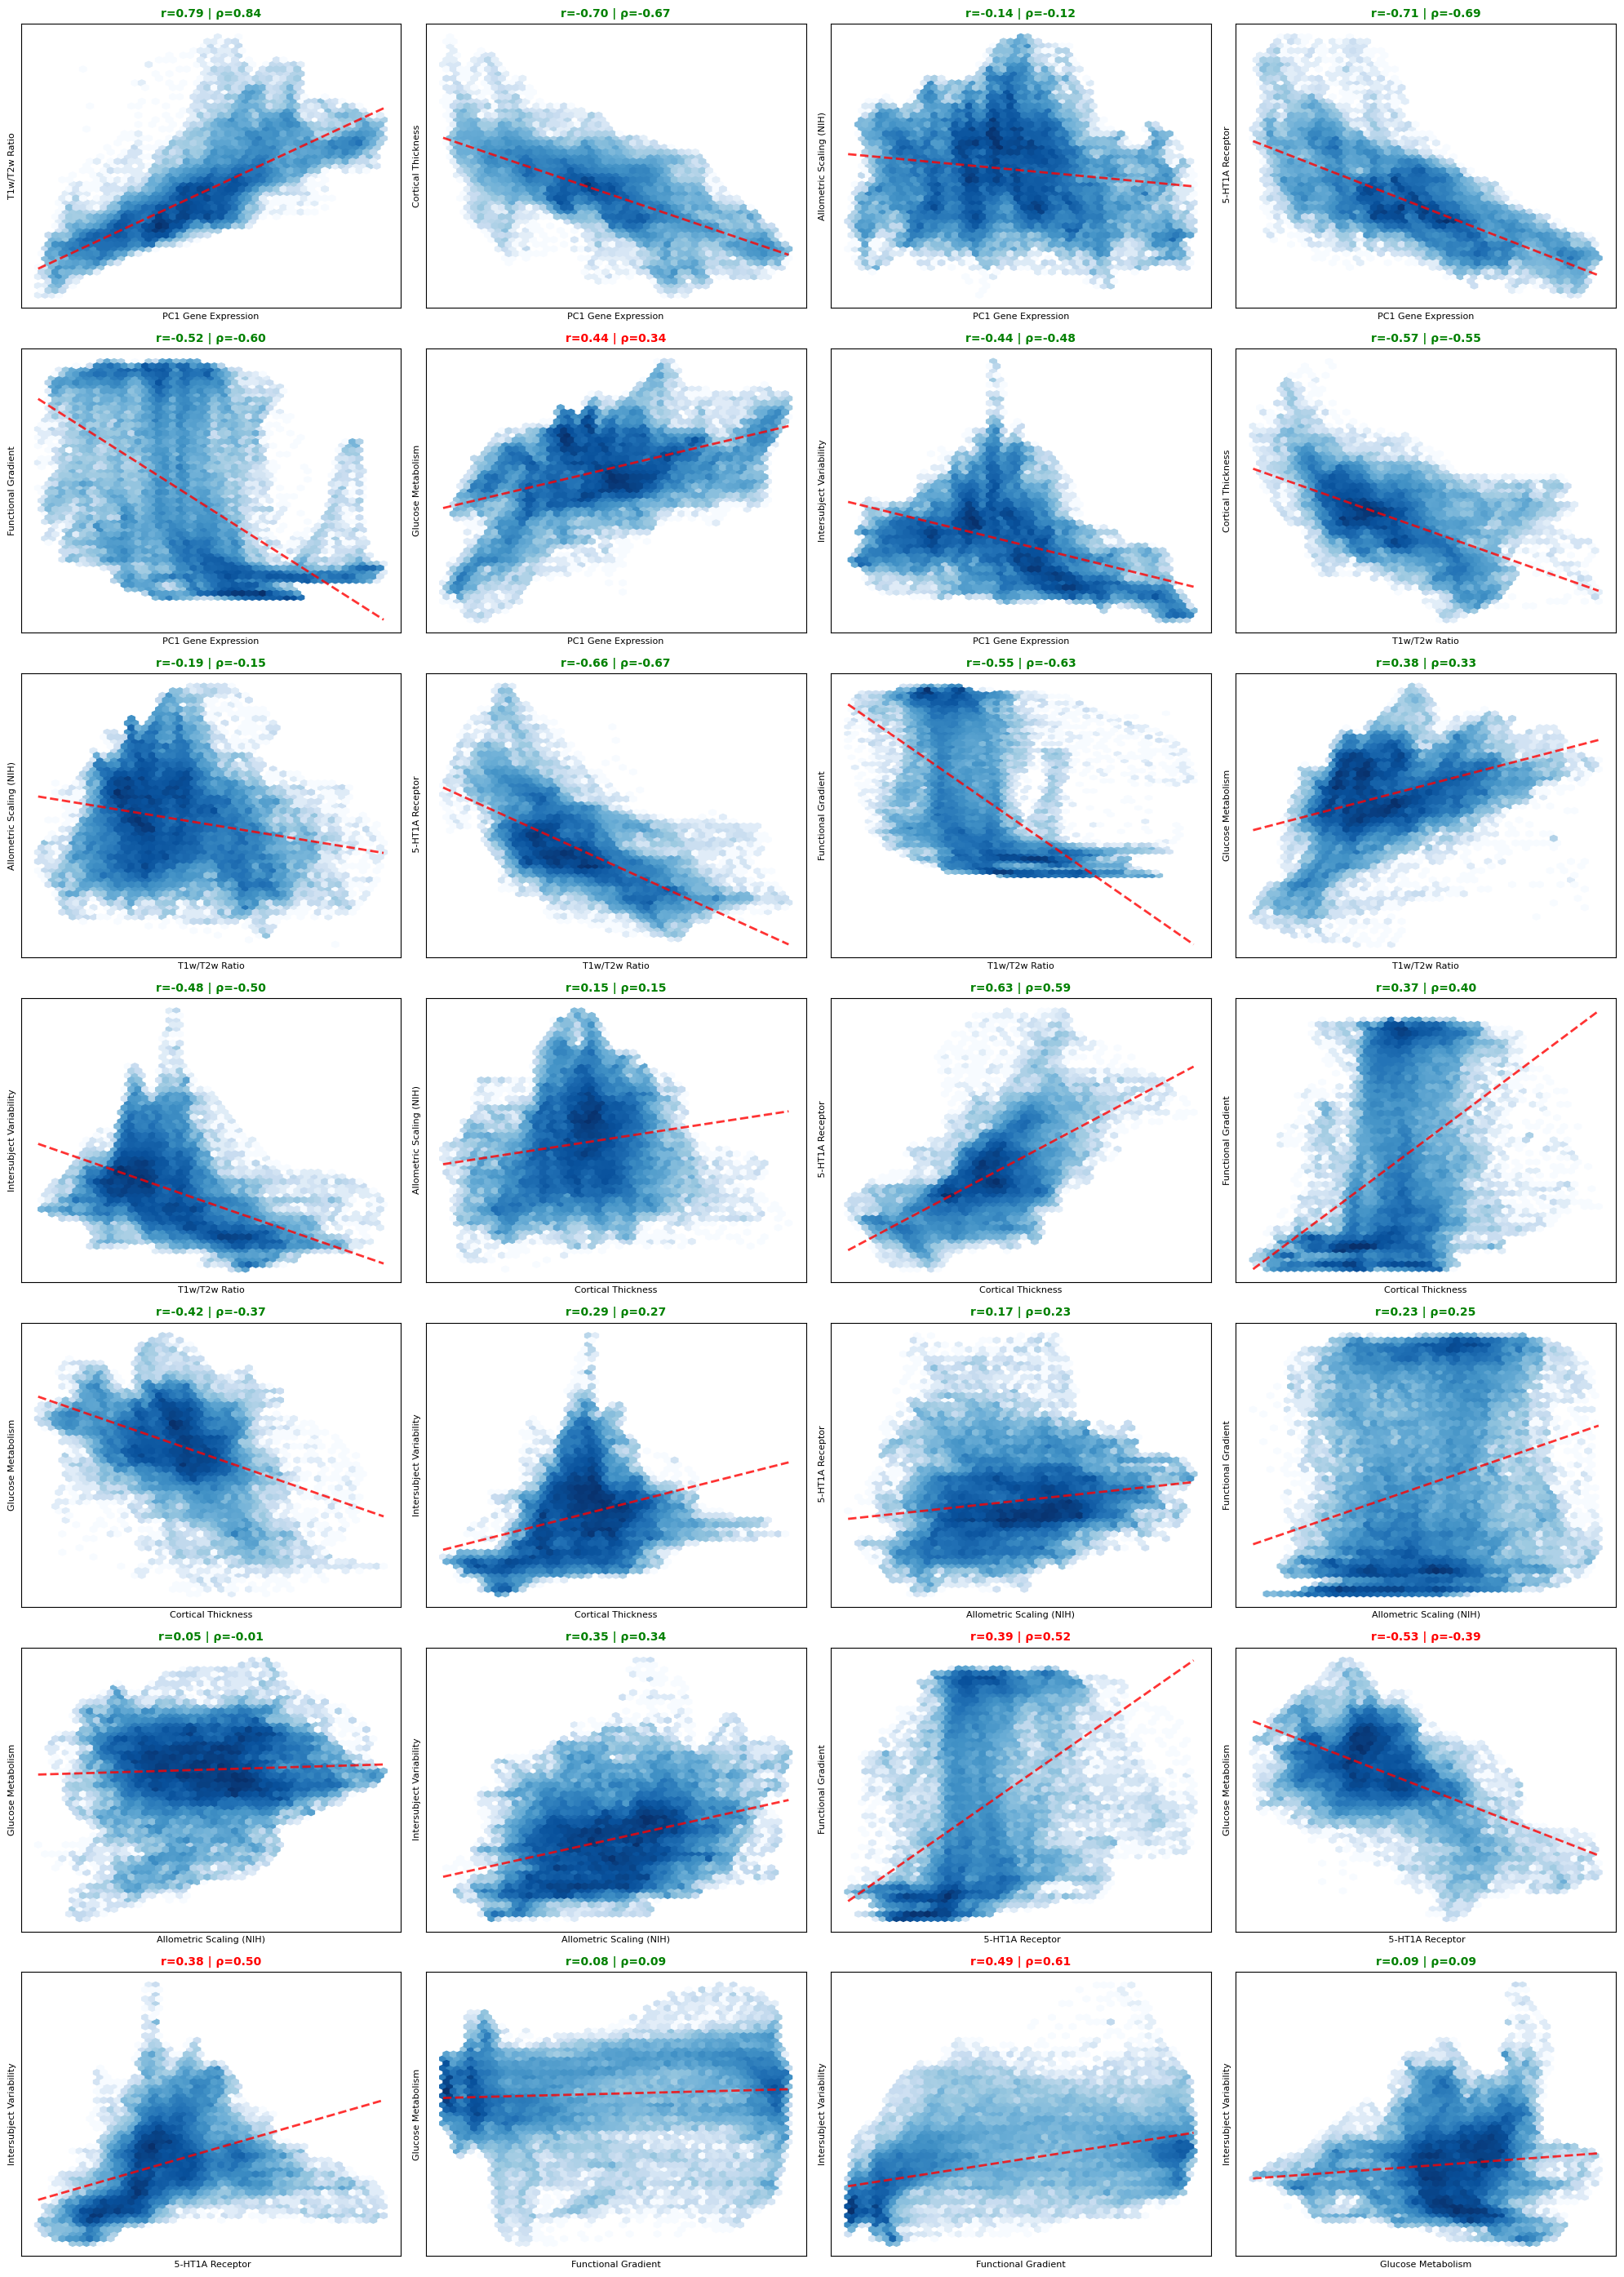

In [7]:
plot_pairwise_scatterplots(
    prepared_maps, 
    map_names, 
    readable_map_names=readable_map_names
)
# Green title means the the values are similar so we should use pearson
# red titles mean the values are different so we need to look at the hexbin/scatter plot
    # if it's curved or a dark blob with outliers --> use spearman